# Проверка гипотез по увеличению выручки интернет-магазина.

## Описание проекта.

Отдел маркетинга и аналитик подготовили список гипотез для увеличения выручки крупного интернет-магазина. Нужно проверить гипотезы и понять, что действительно может помочь увеличить выручку.

## Задачи проекта. 

- Приоритизировать гипотезы.
- Запустить A/B-тест. 
- Проанализировать результаты.

## План исследования. 

1. Загрузить данные и подготовить их к анализу.
2. Приоритезировать гипотезы с помощью фреймворков ICE и RICE. 
3. Проанализировать результаты проведённого А/В-теста. 
4. Сделать выводы.

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

## 1. Загрузка и подготовка данных. 

In [2]:
# загружаем файлы
    hypothesis, orders, visitors = (
    pd.read_csv('C:/Users/dnast/Downloads/Проект Принятие решений в бизнесе/hypothesis.csv'),
    pd.read_csv('C:/Users/dnast/Downloads/Проект Принятие решений в бизнесе/orders.csv'),
    pd.read_csv('C:/Users/dnast/Downloads/Проект Принятие решений в бизнесе/visitors.csv'),  
    )

In [3]:
# создаём функцию для проверки данных в файлах

def analyze_file(df):
     # описание данных
    description = df.describe()

    # анализ наиболее часто встречающихся строк с помощью value_counts
    most_frequent_rows = df.apply(tuple, axis=1).value_counts().reset_index()
    most_frequent_rows.columns = ['Строка', 'Частота']

    # первые несколько строк
    first_few_rows = df.head()

    # обзор данных
    data_info = df.info()

    print('*' * 50)  

    return {
        'first_few_rows': first_few_rows,
        'description': description,
        'most_frequent_rows': most_frequent_rows,
        'data_info': data_info
    }


In [4]:
# проверяем данные в гипотезах
analyze_file(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
**************************************************


{'first_few_rows':                                           Hypothesis  Reach  Impact  \
 0  Добавить два новых канала привлечения трафика,...      3      10   
 1  Запустить собственную службу доставки, что сок...      2       5   
 2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
 3  Изменить структура категорий, что увеличит кон...      8       3   
 4  Изменить цвет фона главной страницы, чтобы уве...      3       1   
 
    Confidence  Efforts  
 0           8        6  
 1           4       10  
 2           7        3  
 3           3        8  
 4           1        1  ,
 'description':            Reach     Impact  Confidence    Efforts
 count   9.000000   9.000000    9.000000   9.000000
 mean    4.777778   4.777778    5.555556   4.888889
 std     3.153481   3.192874    3.045944   2.803767
 min     1.000000   1.000000    1.000000   1.000000
 25%     3.000000   3.000000    3.000000   3.000000
 50%     3.000000   3.000000    7.000000   5.000000
 75%     8.0

In [5]:
# переводим названия колонок в нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()

**Пропусков и повторов нет, названия приведены к pep8, форматы данных в столбцах корректные.**

In [6]:
# проверяем данные в заказах
analyze_file(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
**************************************************


{'first_few_rows':    transactionId   visitorId        date  revenue group
 0     3667963787  3312258926  2019-08-15     1650     B
 1     2804400009  3642806036  2019-08-15      730     B
 2     2961555356  4069496402  2019-08-15      400     A
 3     3797467345  1196621759  2019-08-15     9759     B
 4     2282983706  2322279887  2019-08-15     2308     B,
 'description':        transactionId     visitorId       revenue
 count   1.197000e+03  1.197000e+03  1.197000e+03
 mean    2.155621e+09  2.165960e+09  8.348006e+03
 std     1.229085e+09  1.236014e+09  3.919113e+04
 min     1.062393e+06  5.114589e+06  5.000000e+01
 25%     1.166776e+09  1.111826e+09  1.220000e+03
 50%     2.145194e+09  2.217985e+09  2.978000e+03
 75%     3.237740e+09  3.177606e+09  8.290000e+03
 max     4.293856e+09  4.283872e+09  1.294500e+06,
 'most_frequent_rows':                                                Строка  Частота
 0       (3667963787, 3312258926, 2019-08-15, 1650, B)        1
 1        (4167421281, 

In [7]:
# меняем названия колонок
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId':'visitor_id'}, inplace=True)

In [8]:
# меняем формат колонки с датой
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
# проверка 
analyze_file(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
**************************************************


{'first_few_rows':    transaction_id  visitor_id       date  revenue group
 0      3667963787  3312258926 2019-08-15     1650     B
 1      2804400009  3642806036 2019-08-15      730     B
 2      2961555356  4069496402 2019-08-15      400     A
 3      3797467345  1196621759 2019-08-15     9759     B
 4      2282983706  2322279887 2019-08-15     2308     B,
 'description':        transaction_id    visitor_id       revenue
 count    1.197000e+03  1.197000e+03  1.197000e+03
 mean     2.155621e+09  2.165960e+09  8.348006e+03
 std      1.229085e+09  1.236014e+09  3.919113e+04
 min      1.062393e+06  5.114589e+06  5.000000e+01
 25%      1.166776e+09  1.111826e+09  1.220000e+03
 50%      2.145194e+09  2.217985e+09  2.978000e+03
 75%      3.237740e+09  3.177606e+09  8.290000e+03
 max      4.293856e+09  4.283872e+09  1.294500e+06,
 'most_frequent_rows':                                                  Строка  Частота
 0     (3667963787, 3312258926, 2019-08-15 00:00:00, ...        1
 1     (41

**Изменены названия столбцов по pep8, заменён формат данных в date на корректный, пропусков и повторов нет.**

In [10]:
# проверяем данные в посетителях
analyze_file(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
**************************************************


{'first_few_rows':          date group  visitors
 0  2019-08-01     A       719
 1  2019-08-02     A       619
 2  2019-08-03     A       507
 3  2019-08-04     A       717
 4  2019-08-05     A       756,
 'description':          visitors
 count   62.000000
 mean   607.290323
 std    114.400560
 min    361.000000
 25%    534.000000
 50%    624.500000
 75%    710.500000
 max    770.000000,
 'most_frequent_rows':                   Строка  Частота
 0   (2019-08-01, A, 719)        1
 1   (2019-08-16, B, 413)        1
 2   (2019-08-03, B, 509)        1
 3   (2019-08-04, B, 770)        1
 4   (2019-08-05, B, 707)        1
 ..                   ...      ...
 57  (2019-08-26, A, 722)        1
 58  (2019-08-27, A, 711)        1
 59  (2019-08-28, A, 594)        1
 60  (2019-08-29, A, 577)        1
 61  (2019-08-31, B, 718)        1
 
 [62 rows x 2 columns],
 'data_info': None}

In [11]:
# меняем формат колонки с датой
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
# проверка
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Пропусков и повторов нет, названия по pep8, формат данных в date заменён на корректный.**

## 2. Приоритизация гипотез.

### 2.1. Фреймворк ICE для приоритизации гипотез.

In [13]:
pd.options.display.max_colwidth = 100
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [14]:
# делаем оценку по ICE в новой колонке
hypothesis['ICE'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)

In [15]:
# вывод результата
pd.options.display.max_colwidth = 200
print(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

**В пятёрке приоритетов по гипотезам:** 

**1** (индекс 8) Запустить акцию, дающую скидку на товар в день рождения   
**2** (индекс 0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
**3** (индекс 7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
**4** (индекс 6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
**5** (индекс 2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   

### 2.2. Фреймворк RICE для приоритизации гипотез.

In [16]:
# делаем оценку по ICE в новой колонке
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [17]:
# вывод результата
pd.options.display.max_colwidth = 200
print(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

**В пятёрке приоритетов по гипотезам:** 

**1** (индекс 7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
**2** (индекс 2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
**3** (индекс 0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
**4** (индекс 6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
**5** (индекс 8) Запустить акцию, дающую скидку на товар в день рождения

- Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (индекс 7) перешла с третьего места по ICE на первое место по RICE.
- Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" (индекс 8) с первого места по ICE ушла на 5 место по RICE. 
- Гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" (индекс 0) перешла со второго на третье. 
- А гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" (индекс 2) - с пятого на второе место. 
- Только гипотеза "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" (индекс 6) осталась на том же четвёртом месте. 

**Изменения связаны с оценкой охвата пользователей, которых затронет изменение ("reach").** 

У гипотезы "Запустить акцию, дающую скидку на товар в день рождения" (индекс 8) охват всего лишь 1, 
а у гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (индекс 7) охват все 10 баллов. 

Высокий охват и у гипотезы "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" (индекс 2) - 8 баллов, поэтому она так поднялась.

**Охват имеет большое значение для роста выручки, поэтому предлагается начать проверку приоритетных гипотез по RICE.**

## 3. Анализ A/B-теста.

### 3.1. График кумулятивной выручки по группам.

In [18]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [19]:
# получаем агрегированные кумулятивные данные о заказах по дням и группам
orders_aggregated = (dates_groups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                            .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                     .sort_values(by=['date','group'])
                    )

In [20]:
# получаем агрегированные кумулятивные данные о посетителях интернет-магазина 
visitors_aggregated = (dates_groups
                       .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                              .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                       .sort_values(by=['date','group'])
                      )

In [21]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#даём названия колонкам
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [22]:
# вывод первых строк
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

In [25]:
cumulative_revenue_b.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


In [26]:
# для начала проверим количество покупателей в обеих группах
buyers_number = orders.groupby('group').agg({'visitor_id':'nunique'})
buyers_number.columns = ['buyers']
buyers_number

,buyers
group,
A,503
B,586


**В группе А - 503 покупателя, а в группе В - 586 покупателей. Необходимо проверить, есть ли пересекающиеся покупатели.**

In [27]:
# создаём таблицу с id покупателей и булевым значением: если у покупателя 1 значение группы - True, если нет - False
migrating_status = orders.groupby('visitor_id')['group'].nunique() == 1#

In [28]:
# вывод первых строк
migrating_status.head()

visitor_id
5114589      True
6958315      True
8300375     False
11685486     True
39475350     True
Name: group, dtype: bool

In [29]:
# создаём список id покупателей, у которых больше одной группы
migrating_buyers = migrating_status[migrating_status == False].index

# считаем таких покупателей
count_migrating_buyers = len(migrating_status[migrating_status == False])

# вывод числа покупателей, которые вошли в обе группы
print('Количество покупателей, попавших в обе группы:', count_migrating_buyers)

Количество покупателей, попавших в обе группы: 58


**58 покупателей вошли и в группу А, и в группу В.**
      

**Всего покупателей, которые вошли и в группу А, и в группу В, 58, что составляет 12% от покупателей группы А и 10% от покупателей группы В. 
Эти покупатели видели оба варианта и мы не знаем, что именно повлияло на решение о покупке. Кроме того, есть ли такие "мигрирующие" между группами пользователи без покупок, проверить невозможно, так как данные по ним дали уже агрегированными. С руководителем проекта решено оставить этих пользователей для анализа в датасете и отдельно разобраться, почему данные собраны не совсем корректно.**   

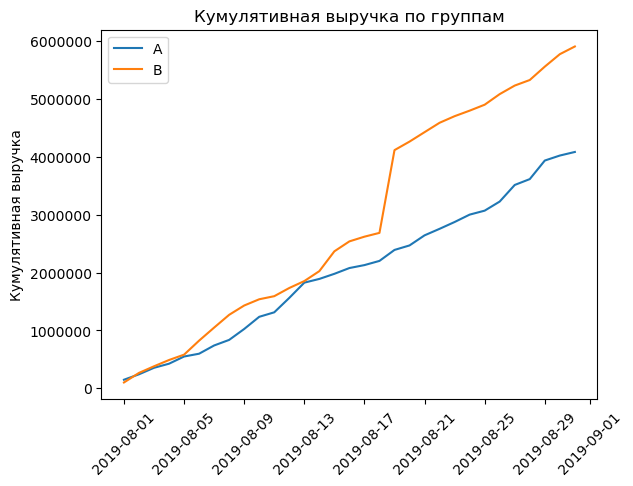

In [33]:
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# форматируем цифры по оси y
plt.ticklabel_format(style='plain', axis='y')

# выводим легенду
plt.legend()

# поворачиваем даты на 45 градусов
plt.xticks(rotation=45) 

# добавляем названия осей и графика
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка по группам')

plt.show();

**Кумулятивная выручка для обеих групп растёт в течение всего теста. Это хороший признак.
У группы В виден резский рост в двух точках, особенно стремительный на неделе 17-21 авуста. Это может говорить об аномалиях (дорогие заказы или большое количество заказов). За счёт этого роста кумулятивная выручка группы В выше по итогам теста, чем группы А. Но для корректного вывода нужно очистить данные от аномалий.** 

### 3.2. График кумулятивного среднего чека по группам.

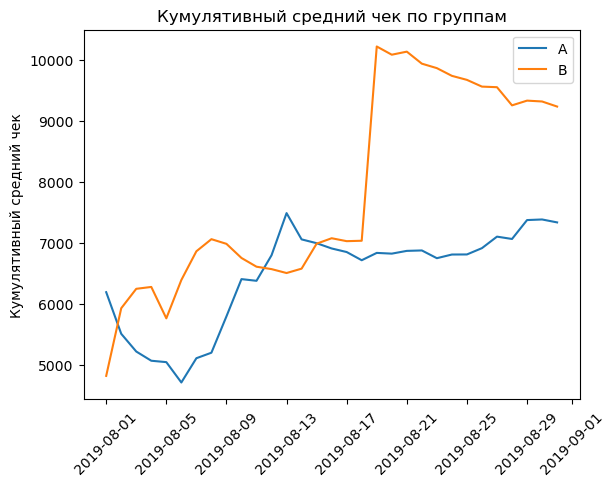

In [34]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()

# поворачиваем даты на 45 градусов
plt.xticks(rotation=45) 

# добавляем названия осей и графика
plt.ylabel('Кумулятивный средний чек')
plt.title('Кумулятивный средний чек по группам')

plt.show();

**Кумулятивный средний чек то растёт, то падает в обеих группах. Из-за этой нестабильности сложно сделать какой-либо вывод.
Однако, средний чек группы В существенно выше, и аномально высокий скачок произошёл также как и в кумулятивной выручке на неделе 17-21 августа, а потом пошёл на спад (но не такой стремительный как был рост). Ещё один признак того, что нужно проверить данные на аномальные заказы.** 

### 3.3. График относительного изменения кумулятивного среднего чека группы B к группе A.

In [35]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, 
                                                       left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [36]:
# создаём функцию для вывода процентов
def percent_formatter(x, pos):
    return f'{x:.0f}%'

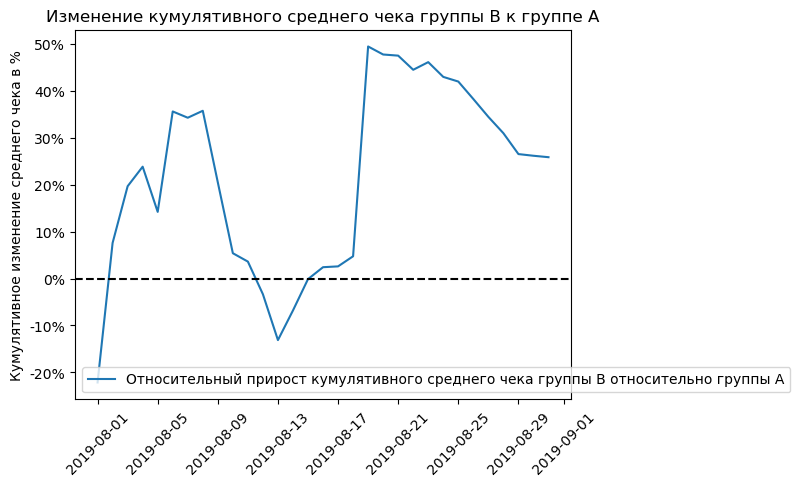

In [37]:
# собираем данные для графика
x_values = merged_cumulative_revenue['date']
y_values = ((merged_cumulative_revenue['revenueB'] / merged_cumulative_revenue['ordersB']) /
            (merged_cumulative_revenue['revenueA'] / merged_cumulative_revenue['ordersA']) - 1) * 100

# создаём график
plt.plot(x_values, y_values,
         label="Относительный прирост кумулятивного среднего чека группы B относительно группы A")

plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)

y_formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# добавляем названия
plt.ylabel('Кумулятивное изменение среднего чека в %')
plt.title('Изменение кумулятивного среднего чека группы B к группе A')

plt.show()


**График среднего чека сильно скачет, что снова указывает на то, что в выборках есть крыпные заказы, меняющие картину.**

### 3.4. График кумулятивного среднего количества заказов на посетителя по группам.

In [38]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [39]:
# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

In [40]:
# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

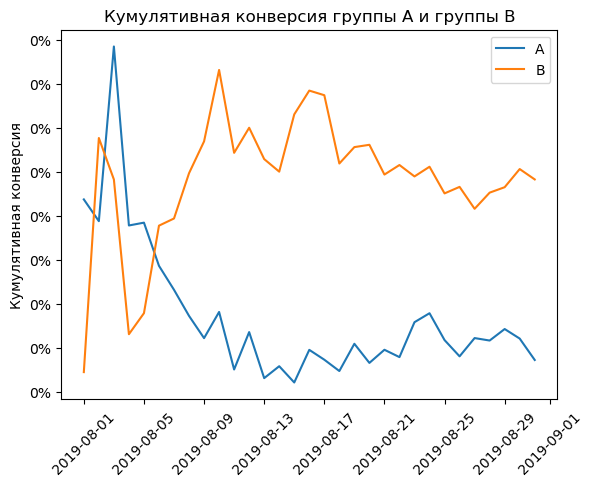

In [41]:
# задаём данные
x_values_a = cumulative_data_a['date']
x_values_b = cumulative_data_b['date']
y_values_a = cumulative_data_a['conversion']
y_values_b = cumulative_data_b['conversion']

# график для группы А
plt.plot(x_values_a, y_values_a, label='A')

# график для группы B
plt.plot(x_values_b, y_values_b, label='B')

plt.legend()
plt.xticks(rotation=45)

# форматирование в проценты
y_formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# названия для осей и графика
plt.ylabel('Кумулятивная конверсия')
plt.title('Кумулятивная конверсия группы A и группы B')

plt.show()


**Конверсия по группам зеркально расходится: группа В идет вверх, а группа А идёт вниз. Видно много шумов (скачки в точках). Лучше исключить аномалии, что быть уверенными в выводах.**

### 3.5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [42]:
# создаем таблицу с данными о конверсии
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B'])

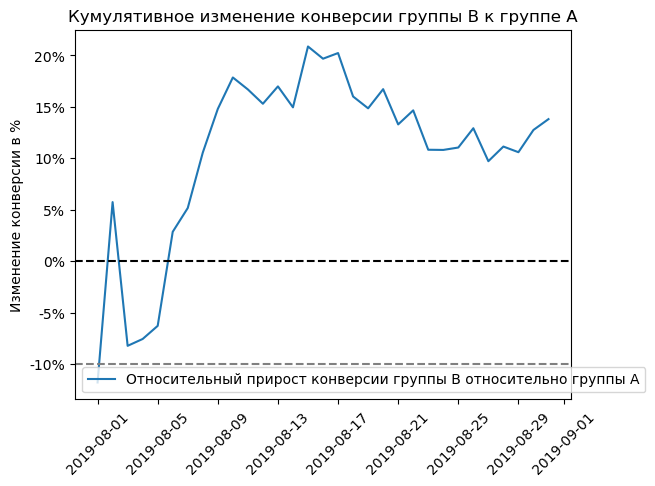

In [43]:
# собираем данные для графика
x_values = merged_cumulative_conversions['date']
y_values = (merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA'] - 1) * 100

# создаём график
plt.plot(x_values, y_values, label="Относительный прирост конверсии группы B относительно группы A")

# выводим легенду
plt.legend()

# задаём линии на 0 и -10 %
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-10, color='grey', linestyle='--')  

# поворачиваем даты на 45 градусов
plt.xticks(rotation=45)

y_formatter = FuncFormatter(percent_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# задаём названия
plt.ylabel('Изменение конверсии в %')
plt.title('Кумулятивное изменение конверсии группы B к группе A')

plt.show()


**Конверсия группы В сначала была значительно ниже группы А, но затем вырвалась вперёд и большую часть теста выше конверсии группы А. При этом видно, что она колеблется - то выше, то ниже. На текущий момент конверсия группы В выше примерно на 14% конверсии группы А.
Окончательно можно сделать вывод, что конверсия группы В значительно выше группы А, когда будут исключены аномалии.** 

### 3.6. Точечный график количества заказов по пользователям.

In [44]:
# группируем количество заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

In [45]:
# даём названия колонкам
orders_by_users.columns = ['visitor_id', 'orders']

In [46]:
# вывод первых строк по убыванию
orders_by_users.sort_values(by='orders', ascending=False).head()

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


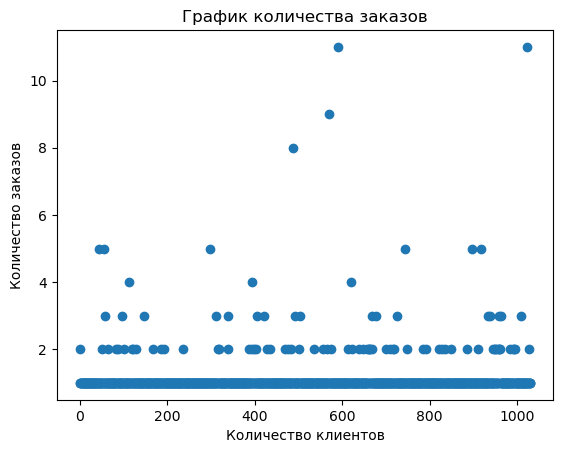

In [47]:
# строим точечный график
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])

# Добавляем названия осей и графика
plt.xlabel('Количество клиентов')
plt.ylabel('Количество заказов')
plt.title('График количества заказов')

plt.show()

**На графике видно, что у большей части клиентов 2 и менее заказов. Проверим это через перцентили.**

### 3.7. 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

In [48]:
# вычисляем перцентили
np.percentile(orders_by_users['orders'], [90, 95, 99])

array([1., 2., 4.])

**- 10% пользователей делали более 1 заказа,**

**- не более 5 % оформляли более 2 заказов,**

**- не более 1 % клиентов заказывали более 4 заказов.**

**Можно считать количество заказов выше 2 аномальным.**

### 3.8. Точечный график стоимостей заказов. 

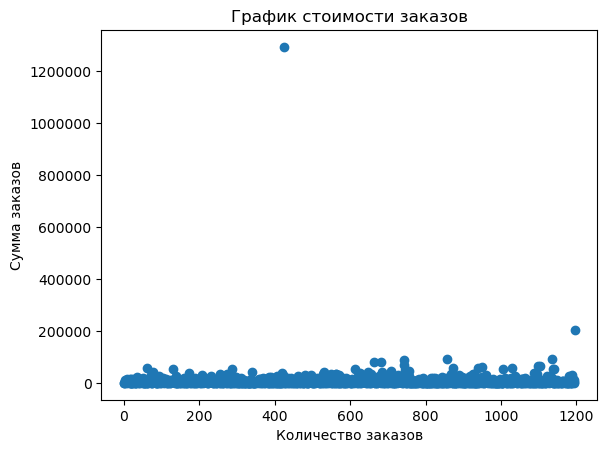

In [49]:
# задаём данные для графика
x_values = pd.Series(range(0, len(orders['revenue'])))
y_values = orders['revenue']

# создаём точечный график
plt.scatter(x_values, y_values)

# форматируем цифры по оси y
plt.ticklabel_format(style='plain', axis='y')

# Добавляем названия осей и графика
plt.xlabel('Количество заказов')
plt.ylabel('Сумма заказов')
plt.title('График стоимости заказов')

plt.show()

**Мы видим очень аномальный заказ - больше 1 млн 200 тысяч. 
При этом практически все заказы стоимостью не больше примерно 50 тысяч. Скорее всего, все заказы сверх 50 тыс. можно считать аномальными, но проверим перцентили.**

### 3.9. 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

In [50]:
# вычисляем перцентили
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

**- не более 10% заказов на сумму более 18 168,**

**- не более 5 % заказов на сумму более 28 000,**

**- не более 1 % заказов на сумму 58 233.**

**Можно считать заказы на сумму свыше 20 000 рублей аномальными.**

### 3.10. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [51]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [52]:
# создаем таблицу заказов по посетителям для группы А 

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users_a.columns = ['visitor_id', 'orders']

In [53]:
# создаем таблицу заказов по посетителям для группы В

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users_b.columns = ['visitor_id', 'orders']

In [54]:
# создаем таблицу количества посетителей по датам для группы А 

visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

In [55]:
# создаем таблицу количества посетителей по датам для группы В

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

In [56]:
# создём таблицу с посетителями (с количеством заказов или с нулями при их отсутствии) для группы А

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_a['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [57]:
# создём таблицу с посетителями (с количеством заказов или с нулями при их отсутствии) для группы В

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_b['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

**Проверим нулевую гипотезу "Cреднее количество заказов на посетителя по «сырым» данным между группами А и В равно" тестом Уилкоксона-Манна-Уитни. 
Альтернативная гипотеза: "Cреднее количество заказов на посетителя по «сырым» данным между группами А и В различается (не равно)".**
 

In [58]:
# проводим тест и считаем относительное различие между средними

display(f"{'Согласно тесту Уилкоксона-Манна-Уитни,'} p-value: {(stats.mannwhitneyu(sample_a, sample_b)[1]):.3f}")

f"{'Относительное различие между средними в количестве заказов групп В и А'}: {(sample_b.mean() / sample_a.mean() - 1):.3f}"


'Согласно тесту Уилкоксона-Манна-Уитни, p-value: 0.017'

'Относительное различие между средними в количестве заказов групп В и А: 0.138'

**p-value меньше 5%, значит, мы отвергаем нулевую гипотезу о равенстве среднего количества заказов на посетителя между группами по «сырым» данным.**

**Относительное различие средних по заказам в группе составляет 13,8% (в группе В больше, чем в группе А).**

### 3.11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

**Проверим нулевую гипотезу "Средние чеки заказов по «сырым» данным между группами А и В равны" тестом Уилкоксона-Манна-Уитни. 
Альтернативная гипотеза: "Cредние чеки заказов по «сырым» данным между группами А и В различаются (не равны)".**
 

In [59]:
# проводим тест и считаем относительное различие между средними

result_1 = "Согласно тесту Уилкоксона-Манна-Уитни, p-value: {:.3f}".format(
    stats.mannwhitneyu(
        orders[orders['group'] == 'A']['revenue'],
        orders[orders['group'] == 'B']['revenue']
    )[1]
)

display(result_1)

result_2 = "Относительное различие в среднем чеке В и А: {:.3f}".format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1
)

result_2

'Согласно тесту Уилкоксона-Манна-Уитни, p-value: 0.729'

'Относительное различие в среднем чеке В и А: 0.259'

**Полученный в ходе теста p-value 0,729 больше заданного уровня значимости 0,05, поэтому статистических отличий между средними чеками по "сырым" данным нет.**

**Относительный прирост среднего чека группы B получился 25,9%. Как мы уже увидели выше, это различие не имеет статистической значимости, так как p-value больше alpha.** 

**Стоит провести тест на очищенных данных, чтобы выводы были более достоверными.**

### 3.12. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

In [61]:
# создаём общий список id пользователей с аномальным количеством заказов

users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 95)]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 95)]['visitor_id'],
    ],
    axis=0,
)

In [63]:
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 90)]['visitor_id']

In [64]:
# создаём общий список id пользователей с аномальным количеством заказов и суммой заказов

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [65]:
# выводим первые строки списка

abnormal_users.head(5)

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
Name: visitor_id, dtype: int64

In [66]:
# выбираем тех пользователей, которых нет в списке аномальных, для группы А

sample_filtered_a = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_a['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [67]:
# выбираем тех пользователей, которых нет в списке аномальных, для группы В

sample_filtered_b = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_b['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

**Проверим нулевую гипотезу "Cреднее количество заказов на посетителя по «очищенным» данным между группами А и В равно" тестом Уилкоксона-Манна-Уитни. 
Альтернативная гипотеза: "Cреднее количество заказов на посетителя по «очищенным» данным между группами А и В различается (не равно)"**. 

In [68]:
# проводим тест и считаем относительное различие между средними

result_3 = "Согласно тесту Уилкоксона-Манна-Уитни, p-value: {:.3f}".format(
    stats.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]
)

display(result_3)

result_4 = "Относительное различие между средними в количестве заказов групп В и А: {:.3f}".format(
    sample_filtered_b.mean() / sample_filtered_a.mean() - 1
)

result_4

'Согласно тесту Уилкоксона-Манна-Уитни, p-value: 0.019'

'Относительное различие между средними в количестве заказов групп В и А: 0.172'

**p-value также как и в "сырых" данных оказался меньше меньше 5%, значит, мы отвергаем нулевую гипотезу о равенстве среднего количества заказов на посетителя между группами по очищенным данным.**

**Относительное различие средних по заказам в группе составляет уже больше - 17% (в группе В больше, чем в группе А).**

### 3.13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

**Проверим нулевую гипотезу "Средние чеки заказов по «очищенным» данным между группами А и В равны" тестом Уилкоксона-Манна-Уитни.** 
**Альтернативная гипотеза: "Cредние чеки заказов по «очищенным» данным между группами А и В различаются (не равны)".**
 

In [69]:
display(f"Согласно тесту Уилкоксона-Манна-Уитни, p-value: {'{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'], orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1])}")


'Согласно тесту Уилкоксона-Манна-Уитни, p-value: 0.619'

In [70]:
result_5 = "Согласно тесту Уилкоксона-Манна-Уитни, p-value: {:.3f}".format(
    stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users))
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users))
            )
        ]['revenue']
    )[1]
)

display(result_5)

result_6 = "Относительное различие в среднем чеке В и А: {:.3f}".format(
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormal_users)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormal_users)),
        )
    ]['revenue'].mean()
    - 1
)

result_6


'Согласно тесту Уилкоксона-Манна-Уитни, p-value: 0.619'

'Относительное различие в среднем чеке В и А: -0.049'

**p-value 0,619 выше 0,05 (как и в сырых данных), поэтому мы не отвергаем нулевую гипотезу о равенсте средних чеков групп А и В. 
А вот относительное изменение среднего чека группы B полностью изменилось: если на сырых данных был прирост 25,9%, то на очищенных данных видна убыль на -3%.** 

<div style="border:solid Chocolate 2px; padding: 40px">

## Общий вывод.

#### Предобработка данных. 

На этапе предобработки не выявлено дубликатов и пропусков. Были скорректированы заголовки столбцов согласно pep8, заменены форматы дат на datetime. 

#### Приоритезация гипотез. 

Так как охват пользователей, которых затронет изменение, имеет большое значение для роста выручки, предлагается начать проверку приоритетных гипотез по RICE. В пятёрке приоритетов гипотезы:
    
7    Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   

#### Анализ итогов А/В теста по кумулятивным метрикам на графиках.

На всех графиках видны скачки разной интенсивности, что говорит о наличии аномалий и не даёт сделать окончательный вывод:

 - Кумулятивная выручка для обеих групп растёт в течение всего теста. У группы В выручка значительно выше. Видны резкие скачки в нескольких точках.
 
- Кумулятивный средний чек то растёт, то падает в обеих группах. Однако, средний чек группы В существенно выше и есть аномально высокий скачок.

- Изменение кумулятивного среднего чека группы В к группе А сильно скачет, невозможно сделать вывод.

- Кумулятивная конверсия по группам зеркально расходится: группа В идет вверх, а группа А идёт вниз. Видно много шумов (скачки в точках). 

- Изменение кумулятивной конверсии группы В сначала было значительно ниже группы А, но затем вырвалось вперёд и большую часть теста выше конверсии группы А. При этом видно, что оно колеблется - то выше, то ниже, но уже не опускается ниже группы А, всегда значительно выше. 

####  Выявление аномалий. 

- Не более 5 % оформляли более 2 заказов, поэтому считаем количество заказов выше 2 аномальным.

- Не более 10% заказов на сумму более 18 168, считаем заказы на сумму свыше 20 000 рублей аномальными.

####  Проверка гипотез по «сырым» данным.

- Отвергаем нулевую гипотезу о равенстве среднего количества заказов на посетителя между группами, относительное различие средних по заказам в группах составляет 13,8% (в группе В конверсия выше, чем в группе А).

- Статистических отличий между средними чеками в группах нет. Однако относительный прирост среднего чека группы B получился 25,9%.Что довольно странно. 

####  Проверка гипотез по «очищенным» данным.

- Также как и в "сырых" данных отвергаем нулевую гипотезу о равенстве конверсий. Относительное различие средних по заказам в группе составляет уже больше - в группе В конверсия выше на 17% , чем в группе А.

-  Как и в "сырых" данных, мы не отвергаем нулевую гипотезу о равенсте средних чеков групп А и В. 
А вот относительное изменение среднего чека группы B полностью изменилось: видна убыль на -3%.


<div style="border:solid Chocolate 2px; padding: 40px">

### Основные выводы и рекомендации по тесту:

 - Есть статистически значимое различие по конверсии между группами как по "сырым" данным, так и по данным, очищенным от аномалий.
 - По "сырым" данным у группы В средний чек на 25% выше, однако после очистки от аномалий у группы В чек стал ниже на 3%.
 - График различия конверсии между группами показывает, что результаты группы B лучше группы A: большую часть теста конверсия у В растёт и находится выше конверсии А. Однако конверсия не зафиксировалась, недавно было небольшое падение и снова пошёл рост.
 - График различия среднего чека колеблется так сильно, что сделать из этого графика определённые выводы нельзя.
 

**Рекомендуется остановить тест, так как преимущество конверсии в группе В не падает ниже 10% и группу В можно признать победителем теста.**